[3625 3715 3870 ... 5560 5700 5570]
[3625 3715 3870 ... 5560 5700 5570]
[[3625]
 [3715]
 [3870]
 ...
 [5560]
 [5700]
 [5570]]
2311 257


C:\Program Files\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


Epoch 1/10
 - 1s - loss: 0.0933 - acc: 4.3309e-04
Epoch 2/10
 - 0s - loss: 0.0418 - acc: 4.3309e-04
Epoch 3/10
 - 0s - loss: 0.0243 - acc: 4.3309e-04
Epoch 4/10
 - 0s - loss: 0.0195 - acc: 8.6618e-04
Epoch 5/10
 - 0s - loss: 0.0155 - acc: 8.6618e-04
Epoch 6/10
 - 0s - loss: 0.0115 - acc: 8.6618e-04
Epoch 7/10
 - 0s - loss: 0.0078 - acc: 8.6618e-04
Epoch 8/10
 - 0s - loss: 0.0047 - acc: 8.6618e-04
Epoch 9/10
 - 0s - loss: 0.0026 - acc: 8.6618e-04
Epoch 10/10
 - 0s - loss: 0.0013 - acc: 8.6618e-04
Train Score: 342.41 RMSE
Predict the Close value of final day: 5607


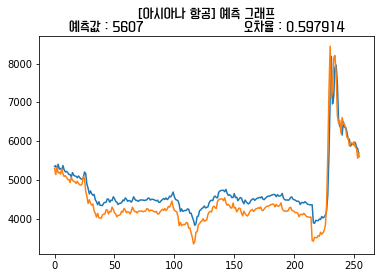

In [7]:
#
# LSTM모델을 이용해서 주가예측
#
import os
import settings
import pandas as pd        # 라이브러리
import numpy as np         # 라이브러리
from keras.models import Sequential      # 딥러닝을 구동하는 데 필요한 케라스 함수
from keras.layers import Dense           # 딥러닝을 구동하는 데 필요한 케라스 함수
from keras.layers import LSTM            # 딥러닝을 구동하는 데 필요한 케라스 함수
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import math
from sklearn.metrics import mean_squared_error
import pymysql         # 파이썬에서 mysql연동시켜주는 라이브러리

#
# DB테이블 값 조회 (SELECT)
#
connection = pymysql.connect(host='222.122.86.187', port=3306, user='geniuses777', password='stock7840',
                       db='geniuses777', charset='utf8')

# 오차율 가져오기
try:
    with connection.cursor() as cursor:
        sql = "select accuracy from stock_hye WHERE company_name='아시아나항공'"
        cursor.execute("set names utf8")
        cursor.execute(sql)
        result_accuracy = cursor.fetchone()
        
        for i in result_accuracy:
            accuracy = i
            
finally:
    connection.close()

    
# 데이터셋 생성 함수
look_back = 1
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i + look_back)]
        dataX.append(a)
        dataY.append(dataset[i + look_back])
    return np.array(dataX), np.array(dataY)
 
#
# 저장되어있는 주식데이터 불러오기
#
sydtpath = os.path.join(settings.BASE_DIR, 'chart_data/%s' % (settings.get_today_str()))
stock_code = "asiana"
fullpath = sydtpath + os.path.sep + stock_code + '.csv'
pandf = pd.read_csv(fullpath, index_col="Date")

# 데이터 전처리
nparr = pandf['Close'].values[1:]     # 맨처음 'Close'데이터부터 차례대로 nparr에 저장
print(nparr)
nparr.astype('float32')    # float형으로 변환
print(nparr)
nparr = nparr.reshape(-1,1)
print(nparr)
 
# 정규화 (0~1사이의 값으로 바꿔준다)
scaler = MinMaxScaler(feature_range=(0, 1))
nptf = scaler.fit_transform(nparr)
 
# 학습용, 테스트용 데이터로 나누기 (90%를 학습용 데이터, 10%를 테스트용 데이터)
train_size = int(len(nptf) * 0.9)
test_size = len(nptf) - train_size
train, test = nptf[0:train_size], nptf[train_size:len(nptf)]
print(len(train), len(test))
 
# 학습을 위한 데이터셋 생성하기 (학습용, 테스트용으로 구분)
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)
 
# RNN모델은 3차원 데이터
# trainX, testX값을 [samples, time steps, features] 형태로 reshape
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))
 
# LSTM모델
model = Sequential()                                                # 딥러닝 구조, 층을 설정
model.add(LSTM(20, input_shape=(1, 1)))     # (timestep, feature)   # 층이 추가됨 (add)   # 입력층, 첫번째 은닉층                   
model.add(Dense(1))                                                 # 출력층 (하나)
# 모델을 컴파일 (컴퓨터가 알아들을 수 있도록)   # 오차함수, 최적화 방법
model.compile(loss='mean_squared_error', optimizer='adam', metrics=['accuracy'])   # metrics : 모델 수행 결과를 나타내게 설정 (과적합 문제 방지)
model.fit(trainX, trainY, epochs=1000, batch_size=50, verbose=2)      # 모델을 실제로 수행     # batch_size : 전체 데이터를 10개씩 사용
                                                                                               # verbose(로깅)  2 : epoch당 나오게

# 예측값 평가하기 (얼마나 정확한지)
testPredict = model.predict(testX)
testPredict = scaler.inverse_transform(testPredict)                 # testPredict : 예측 값
testY = scaler.inverse_transform(testY)                             # testY : 실제 값
testScore = math.sqrt(mean_squared_error(testY, testPredict))       # mean_squared_error : 평균 제곱근 오차
print('Train Score: %.2f RMSE' % testScore)                         # 예측 값과 실제 값 차이 출력
 
# 예측 데이터 출력
lastX = nptf[-1]
lastX = np.reshape(lastX, (1, 1, 1))
lastY = model.predict(lastX)
predict = scaler.inverse_transform(lastY)                    # 정규화 시킨 값을 역변환
print('Predict the Close value of final day: %d' % predict)  # 데이터 입력 마지막 다음날 종가 예측
    
# 차트출력, 저장
font_path = "C:/Windows/Fonts/a옛날목욕탕L.ttf"
fontprop = fm.FontProperties(fname=font_path, size=15)

plt.plot(testPredict)
plt.plot(testY)

plt.title('[아시아나 항공] 예측 그래프\n예측값 : %d \t\t\t\t\t\t\t\t오차율 : %s' % (predict, accuracy), fontproperties=fontprop)

#plt.savefig("./chart_picture/asiana.png",dpi=300)
plt.savefig("C:\source\SPF\chart_picture\\asiana.png", dpi=300)
plt.show()      #자동실행하면 오류

# 사진 데이터 binary형식으로 바꿔주는 함수
def convertToBinaryData(filename):
    #Convert digital data to binary format
    with open(filename, 'rb') as file:
        binaryData = file.read()
    return binaryData


# 
# DB테이블 값 삽입 (INSERT)
#
# MySQL Connection 연결
connection = pymysql.connect(host='222.122.86.187', port=3306, user='geniuses777', password='stock7840',
                       db='geniuses777', charset='utf8')
try:
    with connection.cursor() as cursor:
        sql = 'INSERT INTO stock_hye (company_name, stock_price, image) VALUES (%s, %s, %s) ON DUPLICATE KEY UPDATE stock_price = VALUES(stock_price), image = VALUES(image)'
        image = convertToBinaryData("C:\source\SPF\chart_picture\\asiana.png")
        cursor.execute(sql, ('아시아나항공', int(predict), image))          # 넣으려는 값
    connection.commit()
    
finally:
    connection.close()